In [1]:
!pip install yfinance prophet

In [2]:
from messari.messari import Messari

messari = Messari()
assets = ['bitcoin']
metric = 'price'
start = '2020-01-01'
end = '2023-01-01'
df = messari.get_metric_timeseries(asset_slugs=assets, asset_metric=metric, start=start, end=end)
df = df[f'{assets[0]}']
df = df.reset_index().drop(['open', 'high', 'low', 'volume'], axis=1)
df.rename(columns={'timestamp': 'ds', 'close': 'y'}, inplace=True)

In [3]:
from sklearn.model_selection import train_test_split

period = 7
train, test = train_test_split(df, test_size=period, shuffle=False)
train, val = train_test_split(train, test_size=period, shuffle=False)

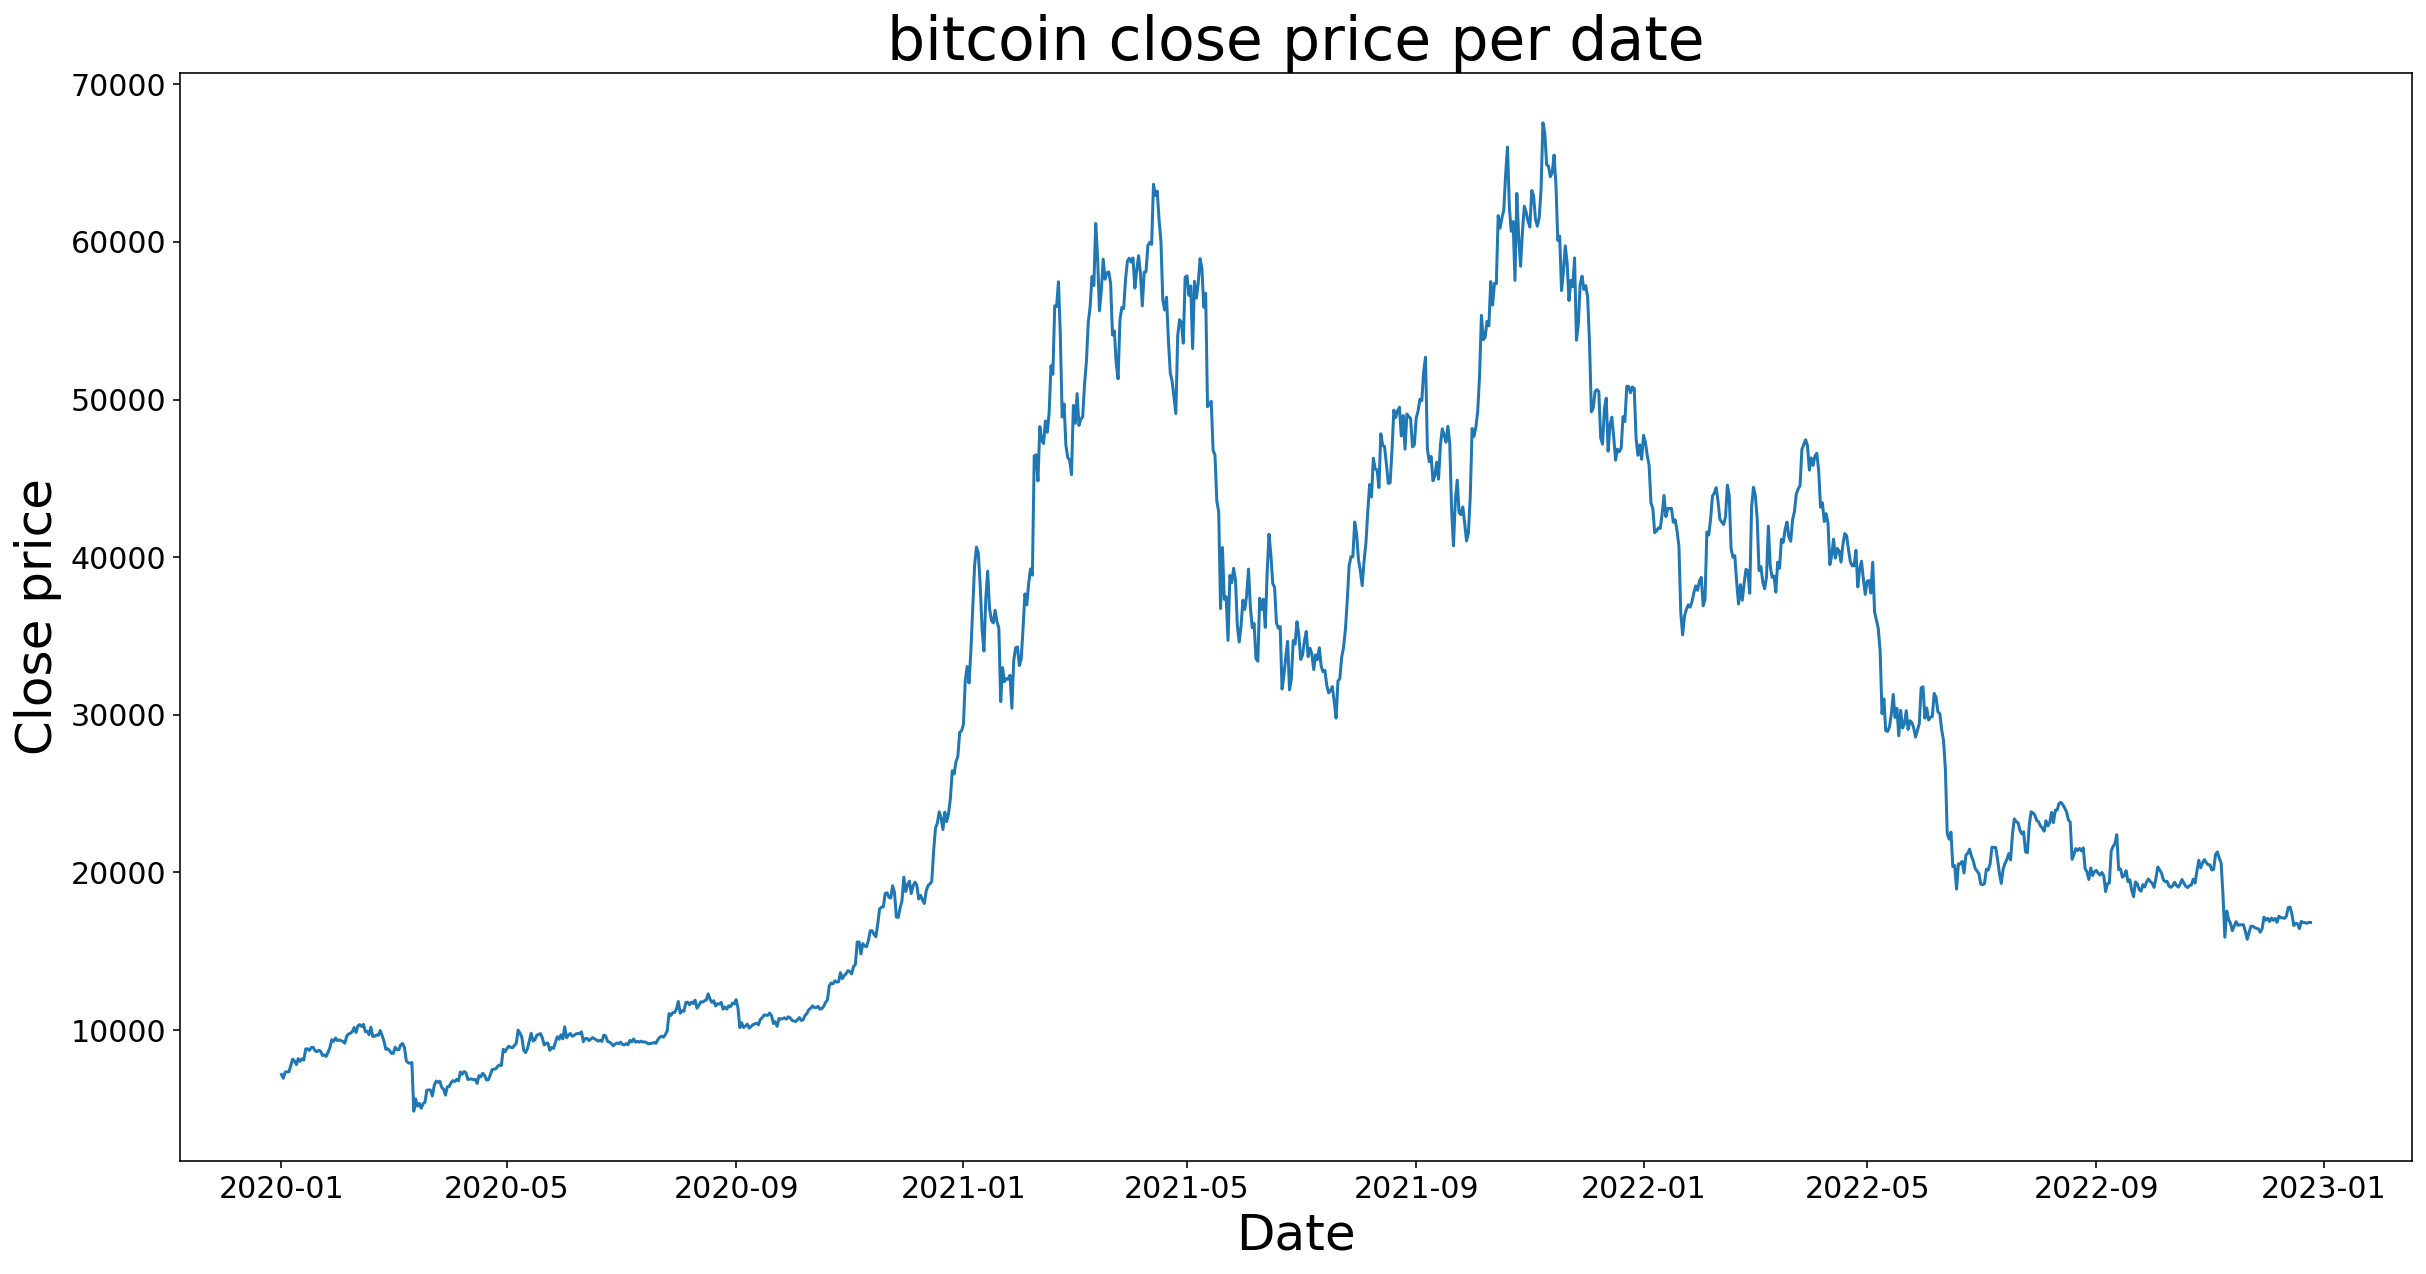

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 20, 10
plt.plot(train['ds'].tolist()+val['ds'].tolist(), train['y'].tolist()+val['y'].tolist())
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Close price", fontsize = 25)
plt.title(f"{assets[0]} close price per date", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [5]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import random

random.seed(42)

changepoint_prior_scale_linspace = np.linspace(0.01, 0.1, num=10)
changepoint_range_linspace = np.linspace(0.8, 0.9, num=3)
best_RMSE = np.inf
best_CPS = 0
best_CR = 0

for changepoint_prior_scale_ in changepoint_prior_scale_linspace:
    for changepoint_range_ in changepoint_range_linspace:
        model = Prophet(changepoint_prior_scale=changepoint_prior_scale_, changepoint_range=changepoint_range_)
        model.fit(train)
        future = model.make_future_dataframe(periods=period)
        forecast = model.predict(future)
        val_pred = forecast['yhat'][-period:]
        RMSE = mean_squared_error(val['y'], val_pred, squared=False)
        if RMSE < best_RMSE:
            best_RMSE = RMSE
            best_CPS = changepoint_prior_scale_
            best_CR = changepoint_range_
              
print("Best RMSE = %.3f" % best_RMSE, sep="")
print("Best changepoint prior scale = ", best_CPS, sep="")
print("Best changepoint range = ", best_CR, sep="")

02:30:54 - cmdstanpy - INFO - Chain [1] start processing
02:30:54 - cmdstanpy - INFO - Chain [1] done processing
02:30:54 - cmdstanpy - INFO - Chain [1] start processing
02:30:55 - cmdstanpy - INFO - Chain [1] done processing
02:30:55 - cmdstanpy - INFO - Chain [1] start processing
02:30:55 - cmdstanpy - INFO - Chain [1] done processing
02:30:55 - cmdstanpy - INFO - Chain [1] start processing
02:30:55 - cmdstanpy - INFO - Chain [1] done processing
02:30:56 - cmdstanpy - INFO - Chain [1] start processing
02:30:56 - cmdstanpy - INFO - Chain [1] done processing
02:30:56 - cmdstanpy - INFO - Chain [1] start processing
02:30:56 - cmdstanpy - INFO - Chain [1] done processing
02:30:57 - cmdstanpy - INFO - Chain [1] start processing
02:30:57 - cmdstanpy - INFO - Chain [1] done processing
02:30:57 - cmdstanpy - INFO - Chain [1] start processing
02:30:57 - cmdstanpy - INFO - Chain [1] done processing
02:30:58 - cmdstanpy - INFO - Chain [1] start processing
02:30:58 - cmdstanpy - INFO - Chain [1]

Best RMSE = 1877.522
Best changepoint prior scale = 0.1
Best changepoint range = 0.8500000000000001


In [6]:
best_model = Prophet(changepoint_prior_scale=best_CPS, changepoint_range=best_CR)
best_model.fit(train.append(val))
best_future = best_model.make_future_dataframe(periods=2*period)
best_forecast = best_model.predict(best_future)
best_forecast = best_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
best_forecast

02:31:21 - cmdstanpy - INFO - Chain [1] start processing
02:31:24 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2020-01-01,10301.394834,7028.692035,13441.043724
1,2020-01-02,10301.525988,7156.542765,13409.861746
2,2020-01-03,10352.561167,7357.825460,13711.874312
3,2020-01-04,10398.695573,7188.918720,13705.960930
4,2020-01-05,10350.998127,7194.241500,13465.661681
...,...,...,...,...
1099,2023-01-04,18643.853250,15594.930763,21763.030976
1100,2023-01-05,18573.472530,15367.957616,21924.279341
1101,2023-01-06,18547.060591,15186.727087,21460.350612
1102,2023-01-07,18511.864008,15307.537294,21621.460487


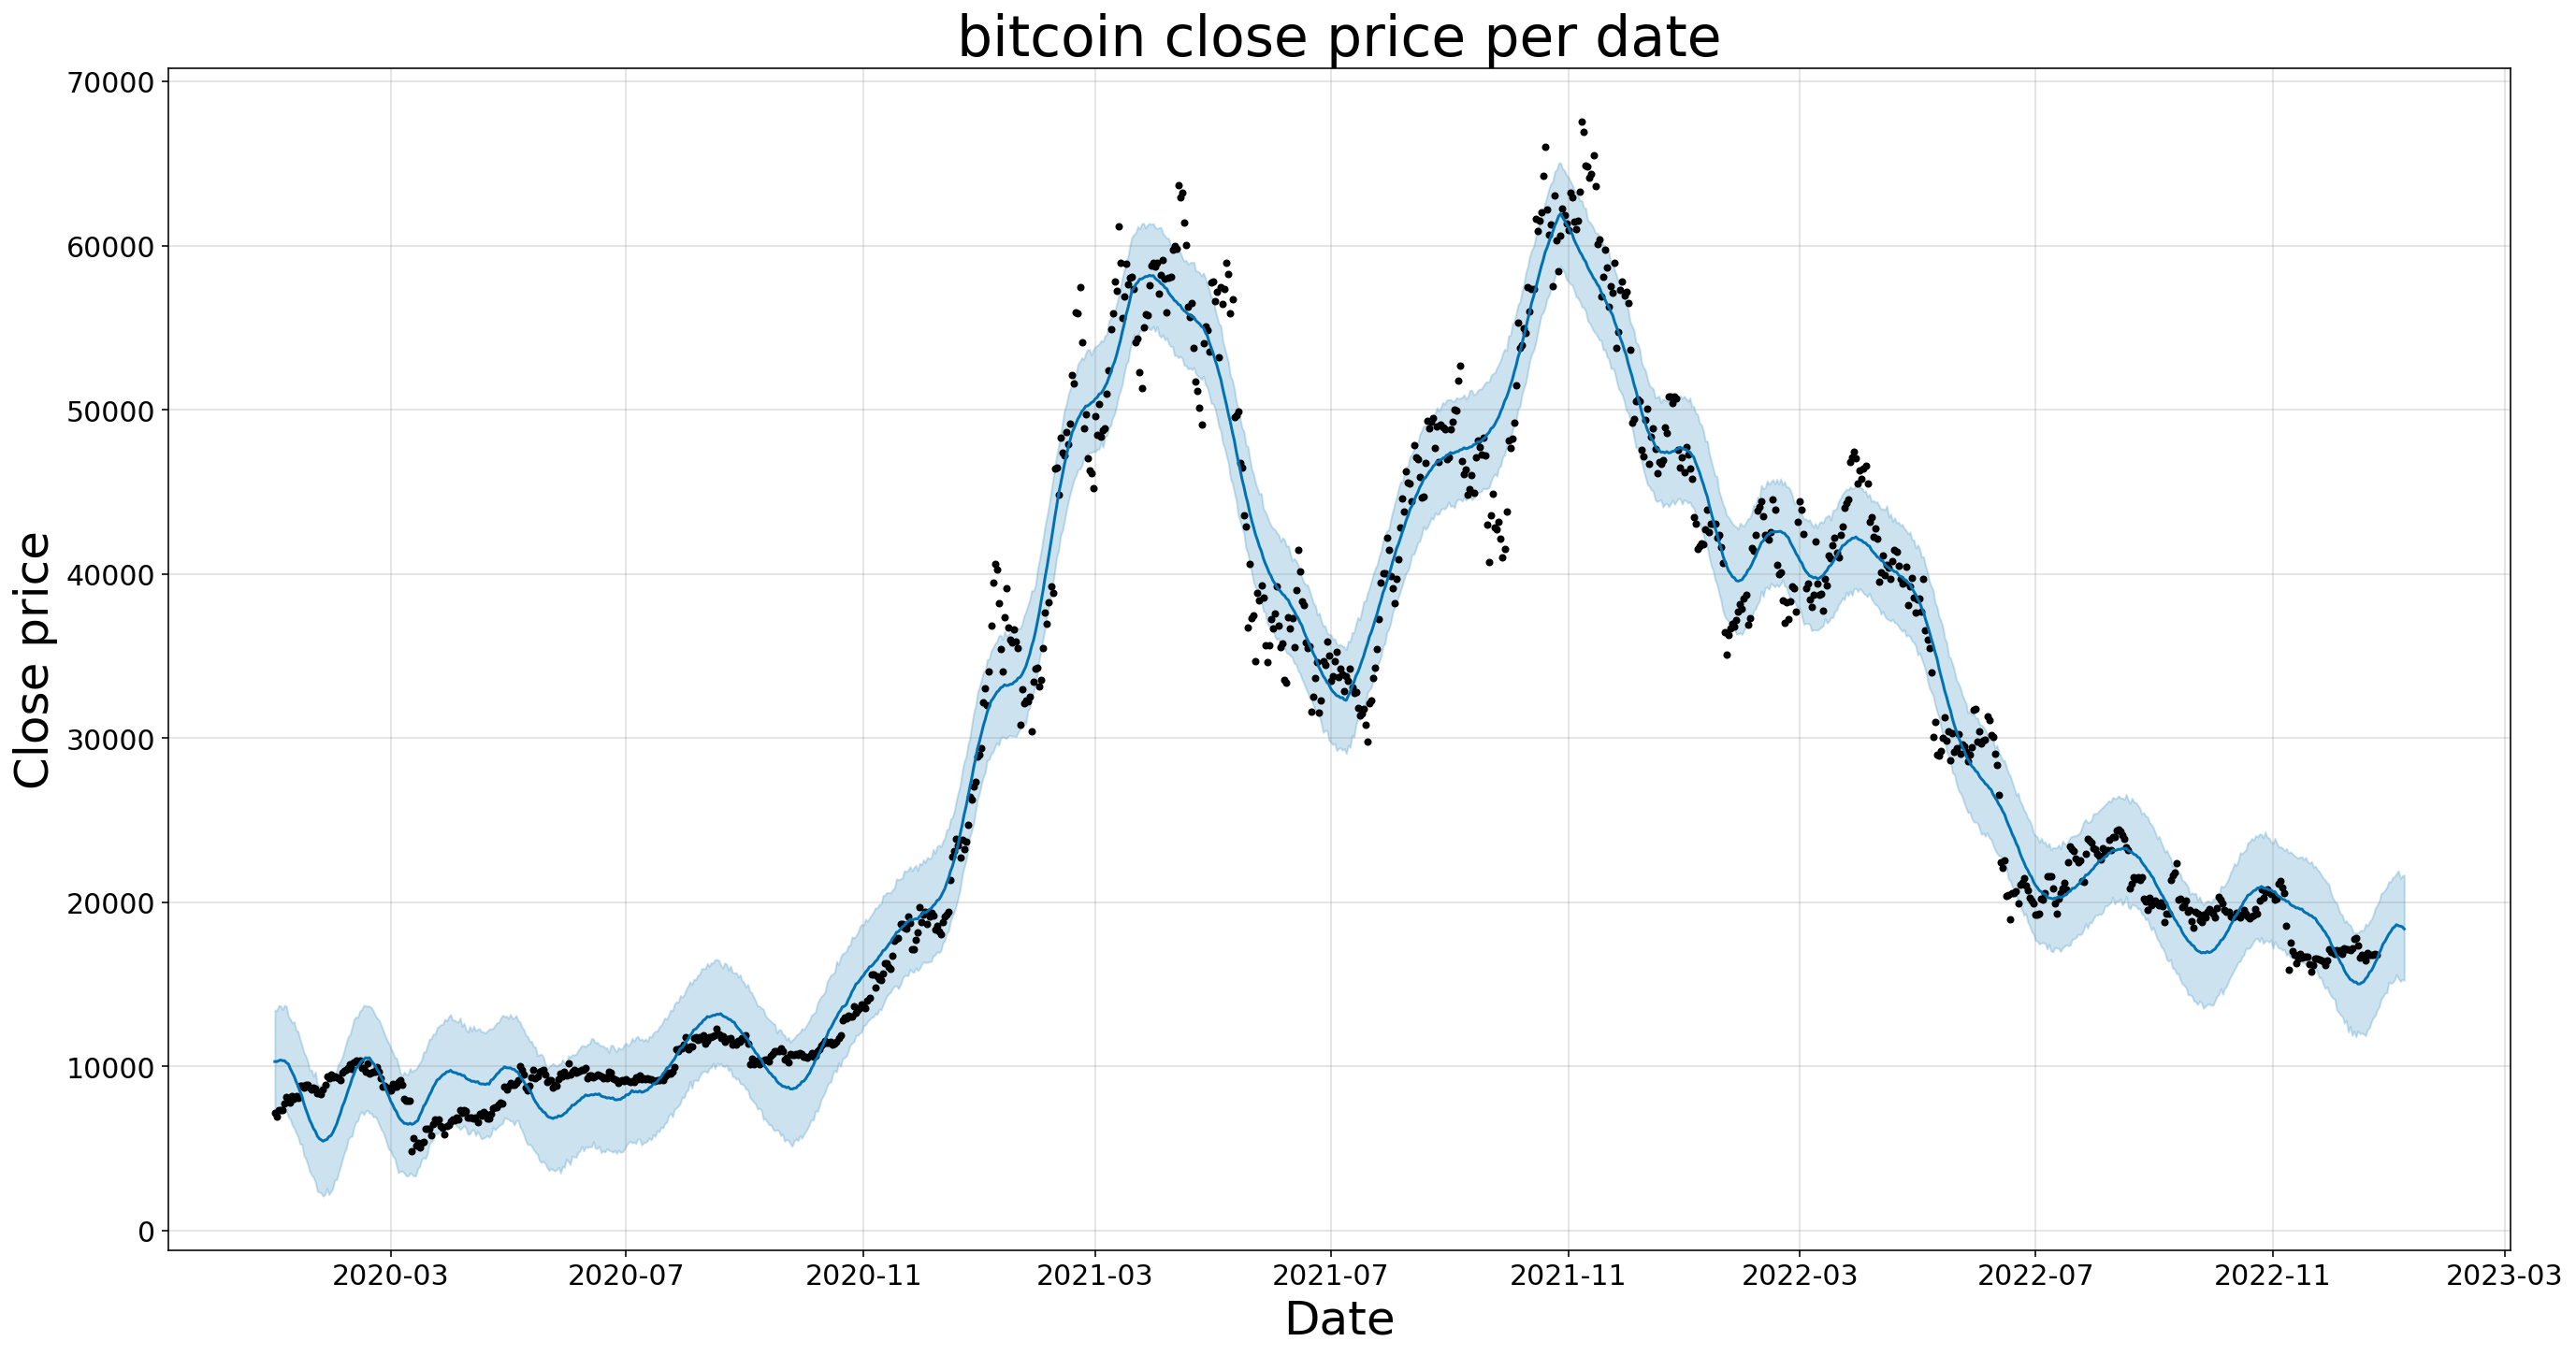

In [7]:
fig = best_model.plot(best_forecast, xlabel='Date', ylabel='Close price')
fig.set_figwidth(20)
fig.set_figheight(10)
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Close price", fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(f"{assets[0]} close price per date", fontsize = 30)
plt.show()

In [8]:
from sklearn.metrics import mean_squared_error
test_pred = best_forecast['yhat'][-2*period:-period]
RMSE = mean_squared_error(test['y'], test_pred, squared=False)
rel_error = ((abs(test_pred - test['y'])) / test['y']) * 100
print("RMSE = %.3f" % RMSE, sep="")
print("Relative error = %.3f" % rel_error.mean(), '%', sep="")
print("Last relative error = %.3f" % rel_error.to_list()[-1], '%', sep="")

RMSE = 1098.599
Relative error = 5.803%
Last relative error = 9.627%


### Future prediction with best model. ###

In [9]:
future_pred = forecast['yhat'][-period:]
last_pred = future_pred.to_list()[-1]
change_pred = (last_pred - df['y'].to_list()[-1]) / df['y'].to_list()[-1] * 100

print(f"Predicted price of {assets[0]} through {period} days = %.3f" % last_pred, sep="")
print(f"{assets[0]} change in percents = %.3f" % change_pred, '%', sep="")

Predicted price of bitcoin through 7 days = 14855.136
bitcoin change in percents = -10.573%
